# Histograms of events time distribution

Divides the full time of acquisition into intervals (bins) and shows the number of events detected in each bin.

###### Import modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as patch
import os
#import csv
#import scipy.stats as sct
#import scipy.optimize as sco
#from random import randrange
import modules_for_python.functions as fc
from modules_for_python.events import Event
from modules_for_python.CAENReader import WDReader
from modules_for_python.CAENReader import readChannels
from modules_for_python.auto_plots import histo_stats
#from collections import Counter

In [4]:
from scipy.optimize import leastsq

###### Settings

In [5]:
### SETTINGS ######################################################################################

###### Settings to read data (options IN)
""" Legend:
        * in_dir -> name of input directory
        * ADC_ch -> number of ADC channels, equal to 2^Nbits
        * nsamp -> number of samples per event
        * deltaT -> real time separation between two samples
        * Vpp -> voltage peak to peak
        * ngroups -> number of groups to study data
        * Nevents -> number of events per group
"""
optin = {   'in_dir':       'wavesh_211105_1146_70h10',
            'ADC_ch':       int(2**14),
            'nsamp':        1030,
            'deltaT':       4,
            'Vpp':          0.5,
            'ngroups':      1,
            'Nevents':      'ind',
            }

cntr_of_fwin = optin['nsamp']/2 # Here is the trigger
# Delays induced by the travel of signals by the cable from antennas to digitizer:
cable_delays = np.array([576.5,574.8,403.0,403.0,286.5,284.7,209.0,207.2]) # ns
# Time of particles from antennas height to floor (where scintillator is)
particle_delay = 30 #ns
# Approximated time of delay of trigger
trigger_delay = 30 #ns
# Total expected pulse delay = cable_delays - particle_delay - trigger_delay
total_delay = cable_delays - particle_delay - trigger_delay
print('Total delay for each channel: ', total_delay, '\n')

win = 100 # width of window in ns. Must be multiple of 4
for i,item in optin.items(): print('%10s: %s' %(i,str(item)))


###### Settings to show and/or save results (options OUT)
optot = {'Show_hists':True,
         'Save_figs': True,
         'Save_stats':True
        }
######

if optot['Save_figs'] or optot['Save_stats']:
    cwd = os.getcwd()
    os.chdir(cwd+'/OUTPUTS')
    list_dir = os.listdir()
    if optin['in_dir'] not in list_dir:
        os.mkdir(optin['in_dir'])
        print(optin['in_dir'],' created in directory OUTPUTS')
    os.chdir(cwd)

Total delay for each channel:  [516.5 514.8 343.  343.  226.5 224.7 149.  147.2] 

    in_dir: wavesh_211105_1146_70h10
    ADC_ch: 16384
     nsamp: 1030
    deltaT: 4
       Vpp: 0.5
   ngroups: 1
   Nevents: ind


In [6]:
baseline = optin['ADC_ch']/2

In [7]:
times = np.arange(0,optin['nsamp']*optin['deltaT'],optin['deltaT'])

In [8]:
READ = readChannels('DATA/'+optin['in_dir'],Vpp=2.0)

file            wave0.dat   size       4086.7 KB
file            wave1.dat   size       4086.7 KB
file            wave2.dat   size       4086.7 KB
file            wave3.dat   size       4086.7 KB
file            wave4.dat   size       4086.7 KB
file            wave5.dat   size       4086.7 KB
file            wave6.dat   size       4086.7 KB
file            wave7.dat   size       4086.7 KB
 Reading file wave0.dat...
  INFO. Reading with header
 Reading file wave1.dat...
  INFO. Reading with header
 Reading file wave2.dat...
  INFO. Reading with header
 Reading file wave3.dat...
  INFO. Reading with header
 Reading file wave4.dat...
  INFO. Reading with header
 Reading file wave5.dat...
  INFO. Reading with header
 Reading file wave6.dat...
  INFO. Reading with header
 Reading file wave7.dat...
  INFO. Reading with header
 Working directory: /home/daniel/Documentos/HYBRID/Antenas


In [9]:
DATA = READ.data()

In [10]:
nevents = READ.nevents()
print('Number of events:', nevents)

Number of events: 1961


In [11]:
file_list = READ.files_list()
print(file_list)

['wave0.dat', 'wave1.dat', 'wave2.dat', 'wave3.dat', 'wave4.dat', 'wave5.dat', 'wave6.dat', 'wave7.dat']


#### Detecting maxima

In [10]:
maxs = {}
for wave in file_list:
    ich = int(wave[-5])
    maxs[ich] = []
    for iev,event0 in DATA[ich].items():
        event = [(item-baseline) for item in event0[1]]
        imax = np.argmax(event)
        maxs[ich].append(times[imax])

#### Plots

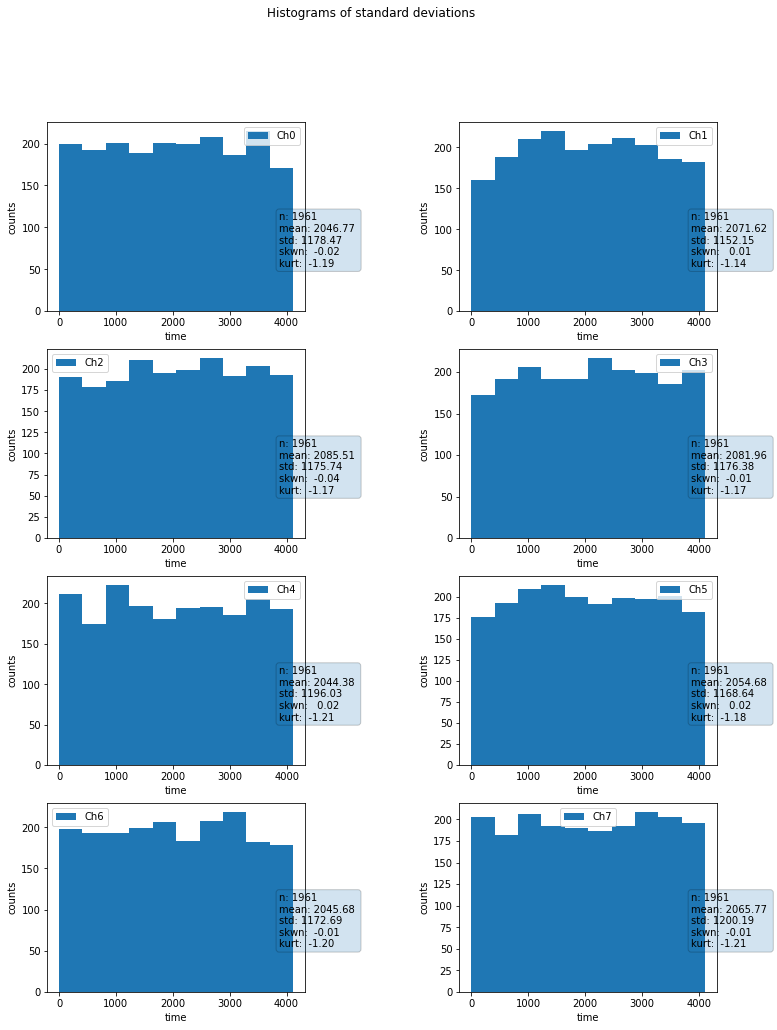

In [16]:
fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.suptitle('Histograms of standard deviations')
fig.subplots_adjust(hspace=0.2,wspace=0.6)

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2

    plotear = histo_stats((maxs[ich],))
    tN, tbines, tpatches = plotear.plot_histo(ax[row][col],
                       labels=('Ch'+str(ich),),
                       #rang = ([lower_limit,upper_limit],),
                       bins = (10,),
                       #pos_stats=[[1.1,0.15],],
                       #log=True,
                       style=(True,))
    (ax[row][col]).set_xlabel('time')
    (ax[row][col]).set_ylabel('counts')
    (ax[row][col]).legend()

#### Computing square deviations and summing them in intervals

In [12]:
time_interval = 41

In [13]:
nsamp = optin['nsamp']
samp_interval = time_interval//optin['deltaT']
print('samples interval: ', samp_interval)
nbins = int(nsamp/samp_interval)
print('number of bins: ', nbins)
histo = {}
time = [(i+0.5)*time_interval for i in range(nbins)]

samples interval:  10
number of bins:  103


In [14]:
for wave in file_list:
    ich = int(wave[-5])
    histo[ich] = np.array([0.0]*nbins)
    print(' Computing channel ', ich)
    for iev,event0 in DATA[ich].items():
        event = event0[1]
        mean_all   = np.mean(event)
        
        for i in range(nbins):
            piece = event[i*samp_interval:(i+1)*samp_interval]
            sqrdev = fc.sqdev(piece,mean_all)
            histo[ich][i] += sqrdev

 Computing channel  0
 Computing channel  1
 Computing channel  2
 Computing channel  3
 Computing channel  4
 Computing channel  5
 Computing channel  6
 Computing channel  7


### Polinomial fit

In [15]:
def poli5(param,a0,x):
    a1,a2,a3,a4,a5 = param
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4 + a5*x**5

In [16]:
def ErrFun(param,x,)

SyntaxError: invalid syntax (<ipython-input-16-c0b24b22d495>, line 1)

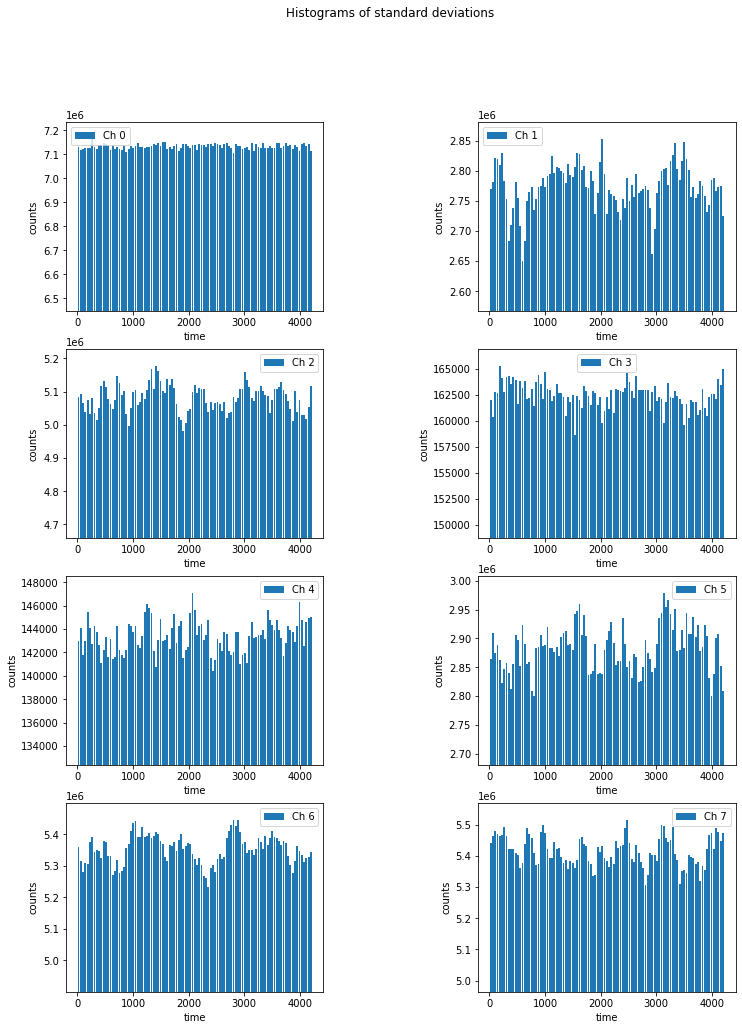

In [17]:
fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.suptitle('Histograms of standard deviations')
fig.subplots_adjust(hspace=0.2,wspace=0.6)

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2

    #(ax[row][col]).plot(time,histo[ich],'o')
    (ax[row][col]).bar(time,histo[ich],label='Ch '+str(ich),width=0.8*time_interval)
    (ax[row][col]).set_xlabel('time')
    (ax[row][col]).set_ylabel('counts')
    maxi = max(histo[ich])
    (ax[row][col]).set_ylim(0.9*maxi,1.01*maxi)
    (ax[row][col]).legend()